find the dataset [here](https://www.kaggle.com/gpucloud/imdb-wiki)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input/imdb-db"))

['imdb_db.mat']


In [2]:
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from scipy.io import loadmat
from datetime import datetime

from keras.models import load_model, Model
from keras.utils import np_utils

Using TensorFlow backend.


In [3]:
#Transfer learning
model = load_model("../input/weights/weights.29-3.76_utk.hdf5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [4]:
#last_layer
last_layer = model.get_layer('average_pooling2d_1').output

In [5]:
def load_data(path):
    d = loadmat(path)
    return d["image"], d["gender"][0], d["age"][0], d["db"][0], d["img_size"][0, 0], d["min_score"][0, 0]

In [6]:
image, gender, age, _, image_size, _ = load_data("../input/imdb-db/imdb_db")

In [7]:
X_data = image
y_data_g = np_utils.to_categorical(gender, 2)
y_data_a = np_utils.to_categorical(age, 101)

In [8]:
image_input = Input(shape=(64, 64, 3))
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
#dense layer for gender prediction
predictions_g = Dense(2, activation='softmax', name='gender')(x)

#dense layer for age prediction
predictions_a = Dense(101, activation='softmax', name='age')(x)

In [9]:
#use the output layer for both gender prediction age prediction
model_custom = Model(model.get_layer('input_1').output, [predictions_a, predictions_g])

In [10]:
model_custom.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [11]:
#train only last layers
for layer in model_custom.layers[:-5]:
    layer.trainable = False

In [12]:
#complie
import keras
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_custom.compile(loss='categorical_crossentropy',optimizer= 'adam', metrics=['accuracy'])

In [13]:
#train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_g, y_test_g, y_train_a, y_test_a=train_test_split(X_data, y_data_g,y_data_a, test_size=0.10, random_state=42,shuffle=True)

In [14]:
# train the model
#using 20% of data as validation data validation_split = 0.2
model_custom.fit(X_train, [y_train_a, y_train_g],validation_split=0.2,batch_size=512, epochs=24)

Train on 123732 samples, validate on 30934 samples
Epoch 1/24
123732/123732 [==============================] - 177s 1ms/step - loss: 3.7714 - age_loss: 3.4440 - gender_loss: 0.2368 - age_acc: 0.0732 - gender_acc: 0.9098 - val_loss: 3.6868 - val_age_loss: 3.3627 - val_gender_loss: 0.2335 - val_age_acc: 0.0795 - val_gender_acc: 0.9120
Epoch 2/24
123732/123732 [==============================] - 166s 1ms/step - loss: 3.6202 - age_loss: 3.3025 - gender_loss: 0.2271 - age_acc: 0.0939 - gender_acc: 0.9132 - val_loss: 3.6773 - val_age_loss: 3.3588 - val_gender_loss: 0.2280 - val_age_acc: 0.0831 - val_gender_acc: 0.9127
Epoch 3/24
123732/123732 [==============================] - 166s 1ms/step - loss: 3.5797 - age_loss: 3.2660 - gender_loss: 0.2232 - age_acc: 0.1045 - gender_acc: 0.9143 - val_loss: 3.6854 - val_age_loss: 3.3635 - val_gender_loss: 0.2313 - val_age_acc: 0.0856 - val_gender_acc: 0.9117
Epoch 4/24
123732/123732 [==============================] - 166s 1ms/step - loss: 3.5496 - age_lo

In [15]:
#validation on test data
scores = model.evaluate(X_test, [y_test_g, y_test_a], batch_size=512)

17186/17186 [==============================] - 21s 1ms/step


In [16]:
model.metrics_names

['loss', 'dense_1_loss', 'dense_2_loss', 'dense_1_acc', 'dense_2_acc']

In [17]:
scores

[3.6545606516271287,
 0.22919750594432425,
 3.313335260495337,
 0.9143488884776793,
 0.09467008029271459]

Here I used 17186 image samples and got the test accuracy of 91.43% on Gender classification and more than 9% on age classification. 

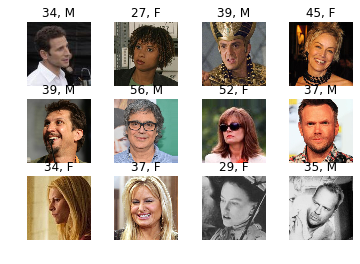

In [19]:
import matplotlib.pyplot as plt
import cv2

cols, rows = 4, 3
test_images = X_test[:12]

results = model.predict(test_images)
predicted_genders = results[0]
ages = np.arange(0, 101).reshape(101, 1)
predicted_ages = results[1].dot(ages).flatten()

for i in range(12):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(test_images[i], cv2.COLOR_BGR2RGB))
    plt.title("{}, {}".format(int(predicted_ages[i]),
                              "F" if predicted_genders[i][0]>0.5 else "M"))
    plt.axis('off')
plt.savefig("result.png")

In [21]:
X_test.shape

(17186, 64, 64, 3)